# 🎓 **Taller 4.8: Taller de Método de Clustering Espectral**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, diags, eye, issparse
from scipy import linalg

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

Cargamos el dataset reducido, para probar este algoritmo

✅ Dataset cargado desde URL GitHub


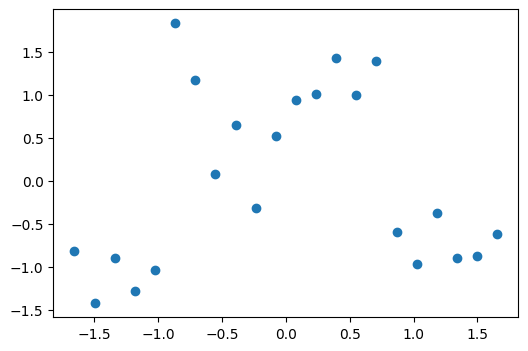

In [3]:
D =cargar_dataset("dataset_reducido.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
Dx = scaler.fit_transform(Dx)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1])

# 🎯 **1:Cree el Algoritmo de Clustering Espectral**

## PASO 1: GRAFO DE SIMILITUD


### Metodo para Graficar un Grafo de Similitud


In [ ]:
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),  # ¡IMPORTANTE: tupla (x, y)!
                   xytext=(3, 3),
                   textcoords='offset points')
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)
    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### a)	El grafo ε-vecindad

In [10]:
# 1. Primero definamos la función grafo_epsilon que ya tienes
def grafo_epsilon(Dx, epsilon, sigma=None):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    # Máscara binaria: 1 si distancia < epsilon
    mascara = distancias < epsilon  # p1: condición de vecindad
    np.fill_diagonal(mascara, 0)  # eliminar self-loops
    if sigma is None:
        # Grafo binario
        W = mascara.astype(float)
    else:
        # Grafo con pesos gaussianos dentro de epsilon
        W = np.exp(-distancias**2 / (2 * sigma**2))
        W = W * mascara  # p2: solo mantener conexiones dentro de epsilon
        np.fill_diagonal(W, 0)
    return W

#### Selección de ε (epsilon) y σ (sigma) en la Construcción del Grafo
1. Para ε (epsilon) - Radio de Vecindad

In [11]:
# 2. Calcular epsilon usando la mediana de las distancias
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals <= epsilon):.2%}")

Método: Mediana
  Epsilon sugerido: 1.9545
  Proporción de conexiones: 50.22%


2. Para σ (sigma) - Ancho del Kernel Gaussiano

In [12]:
# 3. Calcular sigma como la mediana de las distancias filtradas
mascara = distancias < epsilon
distancias_filtradas = distancias[mascara]
sigma = np.median(distancias_filtradas[distancias_filtradas > 0])
print(f"Sigma sugerido: {sigma:.4f}")

Sigma sugerido: 1.1317


In [13]:
# 4. Crear el grafo de epsilon con los parámetros calculados
W = grafo_epsilon(Dx, epsilon=epsilon, sigma=sigma)  # p3

In [14]:
# 5. Antes de graficar, necesito asegurarme de que plt_grafo_afinidad esté definida
# Vamos a definirla aquí también por si acaso
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),
                   xytext=(3, 3),
                   textcoords='offset points')

    # Conexiones
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)

    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

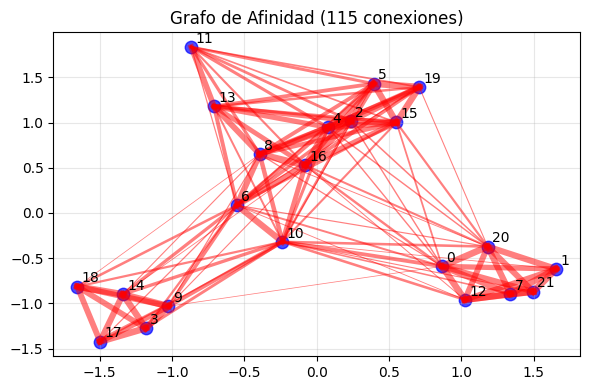

In [15]:
# 6. Ahora sí podemos graficar
plt_grafo_afinidad(Dx, W)

### b)	El grafo k-Vecinos Más Cercanos (k-NN)

In [16]:
def grafo_knn(Dx, knn, sigma=None, modo='interseccion'):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    W_dir = np.zeros((n, n))
    # Construir grafo dirigido de k-NN
    for i in range(n):
        # Índices de los k vecinos más cercanos (excluyendo i)
        indices = np.argsort(distancias[i])[1:knn+1]
        if sigma is None:  # Binario
            W_dir[i, indices] = 1
        else: # Gaussiano
            for j in indices:
                d = distancias[i, j]
                W_dir[i, j] = np.exp(-d**2 / (2 * sigma**2))
    # Aplicar modo de simetría
    if modo == 'dirigido':
        W = W_dir
    elif modo == 'union': # Unión: i-j conectados si i→j O j→i
        W = np.maximum(W_dir, W_dir.T)
    elif modo == 'interseccion': # i-j conectados solo si i→j Y j→i
        W = W_dir * W_dir.T
    elif modo == 'mutuo':  # verifica explícitamente vecindad mutua
        W = np.zeros((n, n))
        for i in range(n):
            vecinos_i = np.where(W_dir[i] > 0)[0]
            for j in vecinos_i:
                if W_dir[j, i] > 0:  # j también tiene a i como vecino
                    W[i, j] = W_dir[i, j]
        W = np.maximum(W, W.T)  # hacer simétrico
    np.fill_diagonal(W, 0)# Eliminar self-loops
    return W

#### 1. Para k (número de vecinos)

##### a) Regla logarítmica (para datos bien comportados):

In [17]:
n = Dx.shape[0]
k_base = int(np.log2(n)) + 1  # Mínimo razonable
k_max = int(np.sqrt(n))       # Máximo razonable
k_recomendado = min(max(k_base, 5), k_max)  # Entre 5 y sqrt(n)
print(f"k recomendado: {k_recomendado}")

k recomendado: 4


##### b) Basado en la dimensionalidad intrínseca:

In [18]:
def estimar_k_por_dimensionalidad(Dx, muestra=1000):
    if len(Dx) > muestra:
        indices = np.random.choice(len(Dx), muestra, replace=False)
        muestra_datos = Dx[indices]
    else:
        muestra_datos = Dx
    n_vecinos = 10  # Para estimación inicial
    neigh = NearestNeighbors(n_neighbors=n_vecinos+1)
    neigh.fit(muestra_datos)
    distancias, _ = neigh.kneighbors(muestra_datos)
    # Estimación simple de dimensionalidad local
    # Ratio entre distancias a vecinos consecutivos
    ratios = distancias[:, 2:] / (distancias[:, 1:-1] + 1e-10)
    dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())
    # k proporcional a dimensionalidad
    k = int(dim_estimada * 5)  # Factor empírico
    return max(5, min(k, int(np.sqrt(len(Dx)))))

In [19]:
# p4: Llamar a la función estimar_k_por_dimensionalidad que definiste antes
k = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k}")

k estimado: 5


#### 2. Para σ (sigma) - Ancho Gaussiano

In [20]:
def sigma_adaptativo_por_punto(Dx, k):
    distancias = euclidean_distances(Dx)
    sigma_local = np.zeros(len(Dx))

    for i in range(len(Dx)):
        # Distancias a los k vecinos más cercanos
        dists_k = np.sort(distancias[i])[1:k+1]  # Excluir self
        # Usar la distancia al k-ésimo vecino o la media
        sigma_local[i] = dists_k[-1]  # o np.mean(dists_k)

    # Para uso global, usar la mediana
    sigma_global = np.median(sigma_local)
    return sigma_global, sigma_local

In [21]:
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")
print(f"Proporción de conexiones: {np.mean(sigma_local <= sigma_global):.2%}")

Sigma global: 3.1233
Proporción de conexiones: 50.00%


In [22]:
# p6: Crear el grafo k-NN con los parámetros calculados
W = grafo_knn(Dx, knn=k, sigma=sigma_global, modo='interseccion')

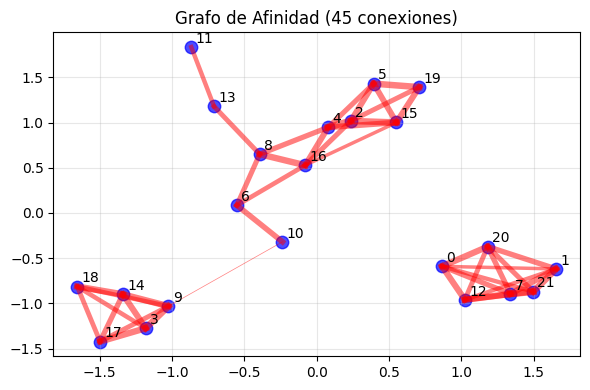

In [23]:
plt_grafo_afinidad(Dx, W)

 ## PASO 2: Calcular la Matriz Laplaciana
 Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

In [25]:
def laplaciano_no_normalizado(mAfinidad):
    # p7: Calcular la matriz diagonal de grados
    D = np.diag(np.sum(mAfinidad, axis=1))
    return D - mAfinidad

In [26]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return # p8u codigo aqui

In [27]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1.0/2)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return # p9 tu codigo aqui

 ## PASO 3: Análisis espectral

In [29]:
def calcula_valores_vectores_propios(mLaplaciana, K):
    # Calcular TODOS los vectores propios
    # p10: Calcular valores y vectores propios
    valores_pr, vectores_pr = linalg.eigh(mLaplaciana)

    # Ordenar por valor propio ascendente
    orden = valores_pr.real.argsort()
    valores_pr = valores_pr.real[orden]
    vectores_pr = vectores_pr.real[:, orden]

    # Tomar los primeros K vectores propios
    # Omitir el primer vector propio (valor ~0)
    # p11: Seleccionar los K vectores propios más pequeños (excluyendo el primero)
    Dx_trans = vectores_pr[:, 1:K+1]  # Índices 1 a K (0 es el primer vector propio con valor ~0)

    return Dx_trans

## PASO 4: Clustering en el Espacio de Vectores Propios

In [30]:
def agrupamiento_espectral(Dx, K, afinidad, laplaciana, **kwargs):
    # Calcular matriz de afinidad
    mAfinidad = afinidad(Dx, **kwargs)

    # p12: Calcular matriz Laplaciana
    mLaplaciana = laplaciana(mAfinidad)

    # p13: Transformar datos al espacio espectral
    Dx_trans = calcula_valores_vectores_propios(mLaplaciana, K)

    # Método de agrupamiento en el espacio transformado
    modelo = KMeans(n_clusters=K)
    modelo.fit(Dx_trans)

    # p14: Obtener las etiquetas de los clusters
    Dyp = modelo.labels_

    return [mAfinidad, Dyp]

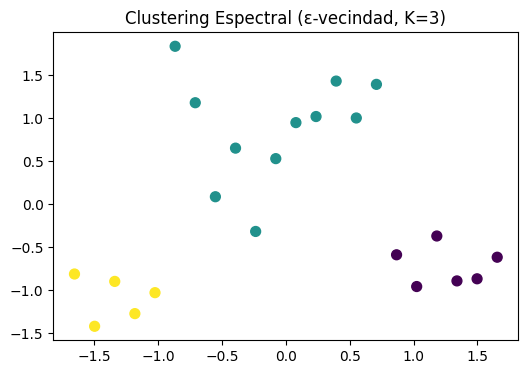

In [31]:
# p15: Elegir número de clusters (para dataset_reducido.xlsx)
K = 3  # Basado en la visualización del dataset

# Usar los valores de epsilon y sigma que calculamos antes
epsilon = epsilon  # Ya calculado anteriormente
sigma = sigma      # Ya calculado anteriormente

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis', s=50)
ax.set_title(f'Clustering Espectral (ε-vecindad, K={K})')
plt.show()

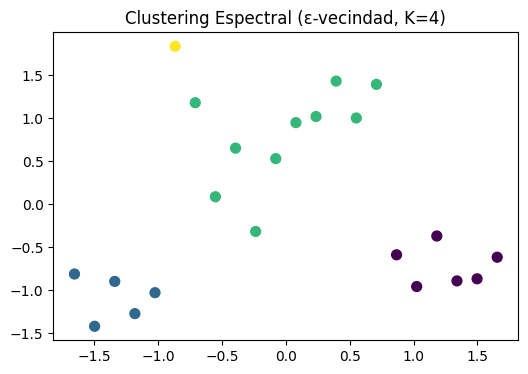

In [32]:
# p16: Probar con diferente número de clusters
K = 4  # Probamos con 4 clusters esta vez

# Usar los mismos epsilon y sigma que antes, o ajustar si es necesario
epsilon = epsilon  # Valor ya calculado anteriormente
sigma = sigma      # Valor ya calculado anteriormente

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis', s=50)
ax.set_title(f'Clustering Espectral (ε-vecindad, K={K})')
plt.show()

# 🎯 **2:Pruebe el Algoritmo de Clustering Espectral**

✅ Dataset cargado desde URL GitHub


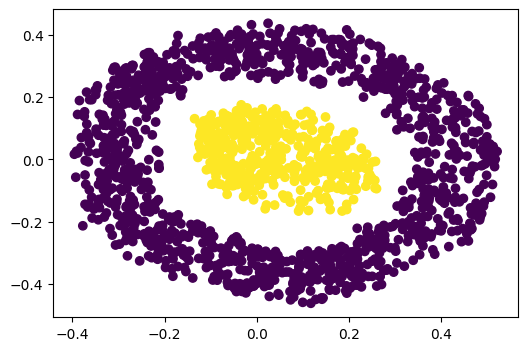

In [33]:
D =cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

## Con el grafo ε-vecindad  y laplaciano no Normalizado

✅ Dataset cargado desde URL GitHub
Epsilon: 1.7681
Sigma: 1.1752


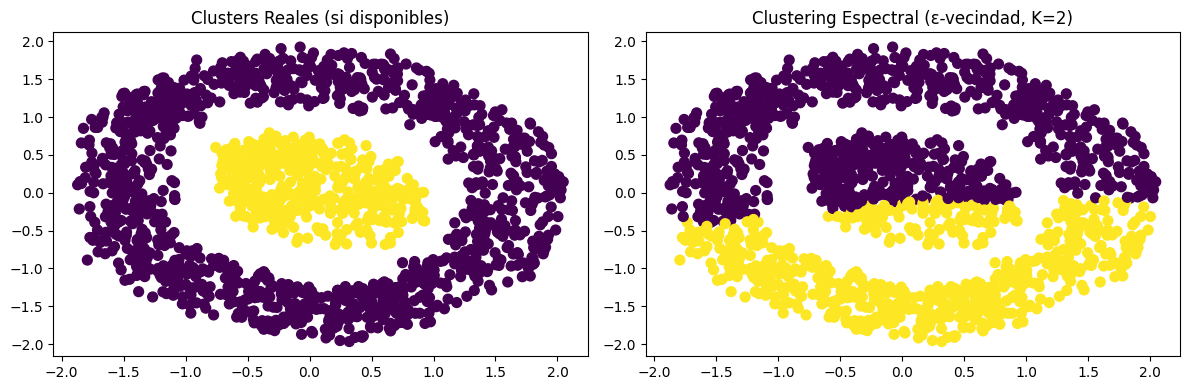

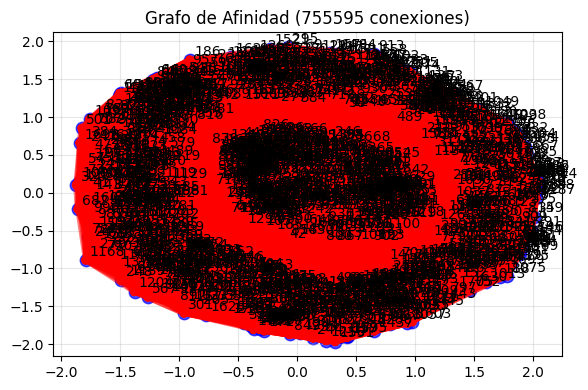

In [34]:
# p17: Clustering espectral para dataset_circulos_concentricos con ε-vecindad

# Cargar y preparar datos
D = cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]
Dx = D[:, 1:3]
Dy = D[:, 3]

# Escalar datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Dx = scaler.fit_transform(Dx)

# Configurar parámetros
K = 2  # Dos círculos concéntricos

# Calcular epsilon y sigma
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)
sigma = np.median(distancias[distancias < epsilon][distancias[distancias < epsilon] > 0])

print(f"Epsilon: {epsilon:.4f}")
print(f"Sigma: {sigma:.4f}")

# Aplicar clustering espectral con ε-vecindad
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado,
                                        epsilon=epsilon, sigma=sigma)

# Graficar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Resultado real (si lo tenemos)
ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=50)
ax1.set_title('Clusters Reales (si disponibles)')

# Resultado del clustering espectral
ax2.scatter(Dx[:, 0], Dx[:, 1], c=Dyp, cmap='viridis', s=50)
ax2.set_title(f'Clustering Espectral (ε-vecindad, K={K})')

plt.tight_layout()
plt.show()

# Opcional: Mostrar grafo de afinidad
plt_grafo_afinidad(Dx, mAfinidad)

## Con El grafo k-Vecinos

k estimado: 31
Sigma global: 0.2296


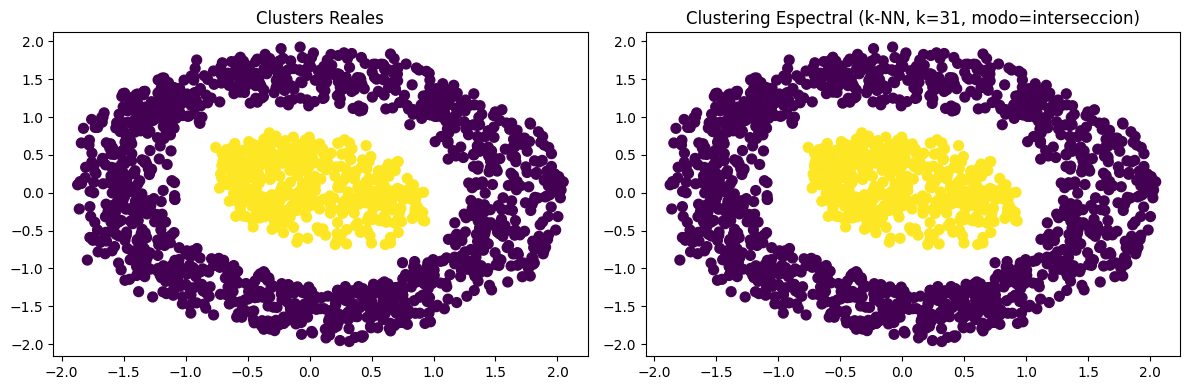

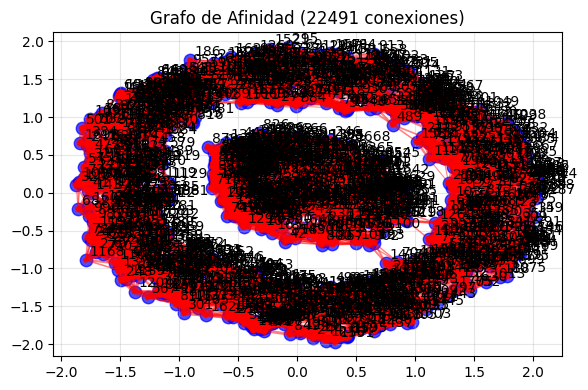

In [35]:
# p18: Clustering espectral para dataset_circulos_concentricos con k-NN

# Datos ya cargados del paso anterior (Dx)
# Si no están cargados, cargar de nuevo:
# D = cargar_dataset("dataset_circulos_concentricos.xlsx")
# D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]
# Dx = D[:, 1:3]
# Dy = D[:, 3]

# Configurar parámetros
K = 2  # Dos círculos concéntricos

# Calcular k automáticamente
k = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k}")

# Calcular sigma adaptativo
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")

# Aplicar clustering espectral con k-NN
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, laplaciano_no_normalizado,
                                        knn=k, sigma=sigma_global, modo='interseccion')

# Graficar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Resultado real (si lo tenemos)
ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=50)
ax1.set_title('Clusters Reales')

# Resultado del clustering espectral
ax2.scatter(Dx[:, 0], Dx[:, 1], c=Dyp, cmap='viridis', s=50)
ax2.set_title(f'Clustering Espectral (k-NN, k={k}, modo=interseccion)')

plt.tight_layout()
plt.show()

# Opcional: Mostrar grafo de afinidad
plt_grafo_afinidad(Dx, mAfinidad)

## Cambiado de Laplaciano


Parámetros: K=2, knn=10, sigma=1.7681, modo='mutuo'


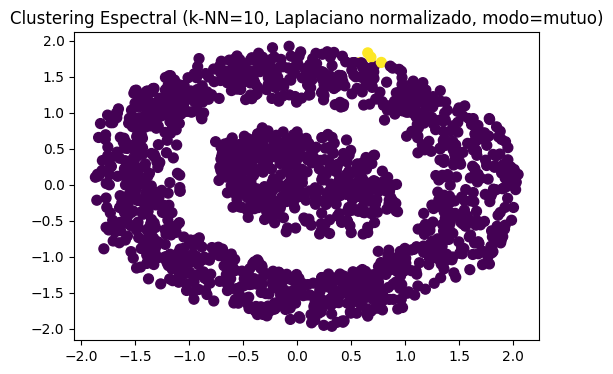

In [38]:
# p19: Clustering espectral con k-NN y Laplaciano normalizado

# Definir la función matriz_Laplaciana_normalizada si no está definida
def matriz_Laplaciana_normalizada(mAfinidad):
    # p8: Laplaciano normalizado: L_norm = I - D^(-1)W
    D = np.sum(mAfinidad, axis=1)
    # Evitar división por cero
    D = np.where(D > 0, D**(-1), 0)
    D = np.diag(D)
    I = np.eye(mAfinidad.shape[0])
    return I - D @ mAfinidad

# Para dataset_circulos_concentricos
K = 2  # Dos círculos concéntricos

# Configurar parámetros k-NN
knn = 10  # Número de vecinos más cercanos

# Calcular sigma automáticamente
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
sigma = np.median(distancias_vals[distancias_vals > 0])  # Mediana de distancias no nulas

print(f"Parámetros: K={K}, knn={knn}, sigma={sigma:.4f}, modo='mutuo'")

# Aplicar clustering espectral
modo = 'mutuo'  # union, interseccion, mutuo
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada,
                                        knn=knn, sigma=sigma, modo=modo)

# Graficar resultados
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis', s=50)
ax.set_title(f'Clustering Espectral (k-NN={knn}, Laplaciano normalizado, modo={modo})')
plt.show()


<hr>
Experimente con el dataset dos remolinos


In [39]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


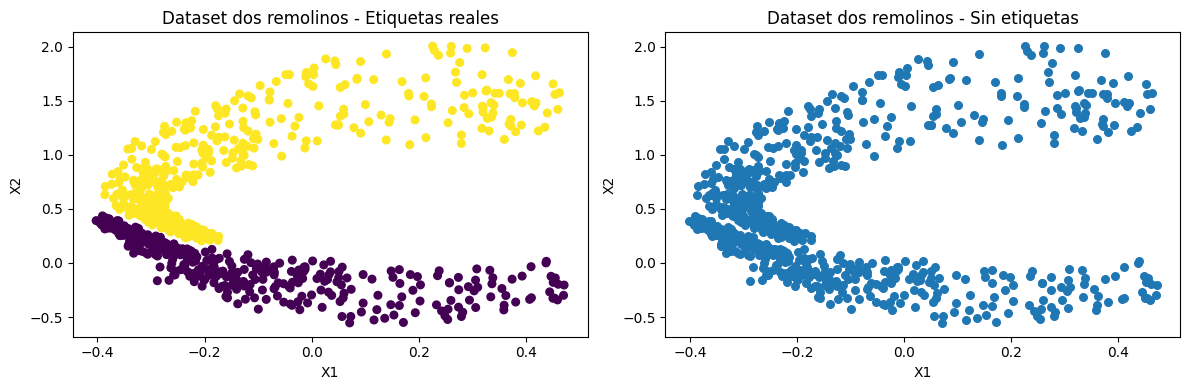

K seleccionado: 2 (dos remolinos)


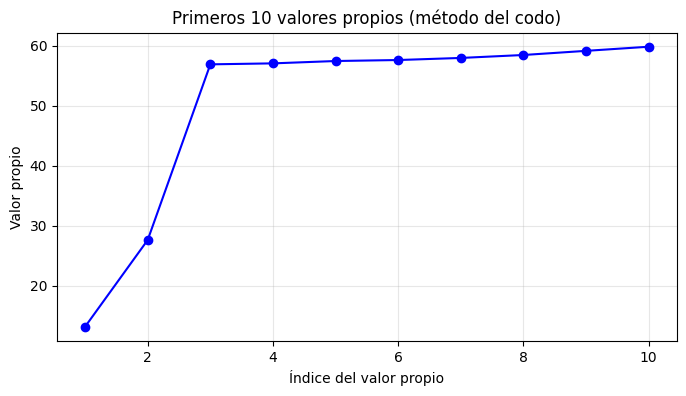

Valores propios más pequeños: [2.27373675e-13 1.31450075e+01 2.76082407e+01 5.68988973e+01
 5.70617134e+01]


In [40]:
# P20: Determinar K para dataset_dos_remolinos

# Visualizar los datos primero
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 1. Datos originales
ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=30)
ax1.set_title('Dataset dos remolinos - Etiquetas reales')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

# 2. Sin colores para ver la estructura
ax2.scatter(Dx[:, 0], Dx[:, 1], s=30)
ax2.set_title('Dataset dos remolinos - Sin etiquetas')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')

plt.tight_layout()
plt.show()

# Basado en la estructura de dos remolinos
K = 2  # Dos estructuras en espiral/remolinos

print(f"K seleccionado: {K} (dos remolinos)")

# Opcional: Método del codo para confirmar
# Escalar los datos primero
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Dx_scaled = scaler.fit_transform(Dx)

# Calcular matriz de afinidad
distancias = euclidean_distances(Dx_scaled)
epsilon = np.median(distancias[np.triu_indices(distancias.shape[0], k=1)])
W = grafo_epsilon(Dx_scaled, epsilon=epsilon, sigma=epsilon)
L = laplaciano_no_normalizado(W)

# Calcular valores propios
valores_pr, _ = linalg.eigh(L)
valores_pr = np.sort(valores_pr)

# Graficar valores propios
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, 11), valores_pr[1:11], 'bo-')
ax.set_xlabel('Índice del valor propio')
ax.set_ylabel('Valor propio')
ax.set_title('Primeros 10 valores propios (método del codo)')
ax.grid(True, alpha=0.3)
plt.show()

print(f"Valores propios más pequeños: {valores_pr[:5]}")

Experimente con el dataset cuatro diferente medida

In [ ]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


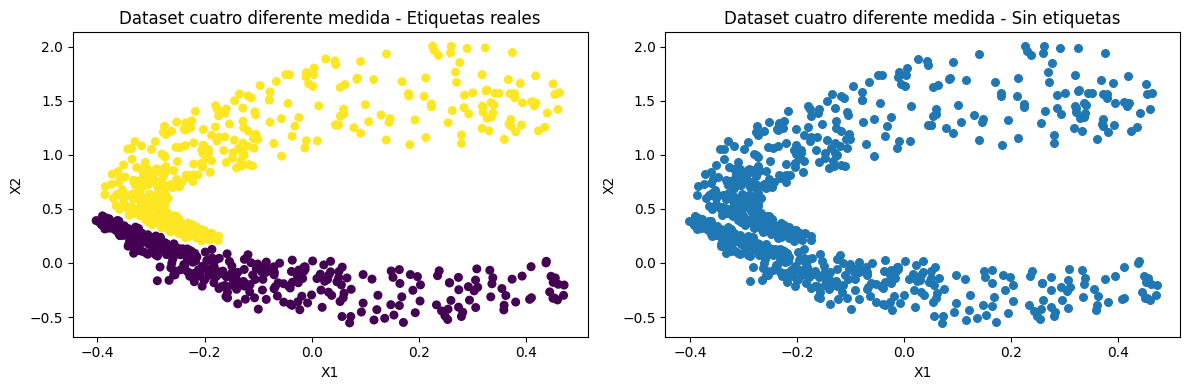

K seleccionado: 4

--- Método 1: k-NN con Laplaciano normalizado ---


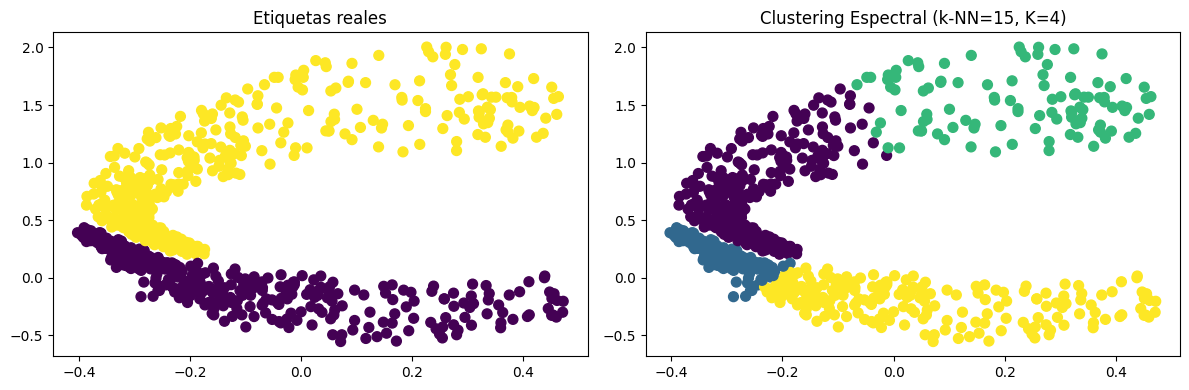


--- Método 2: ε-vecindad ---


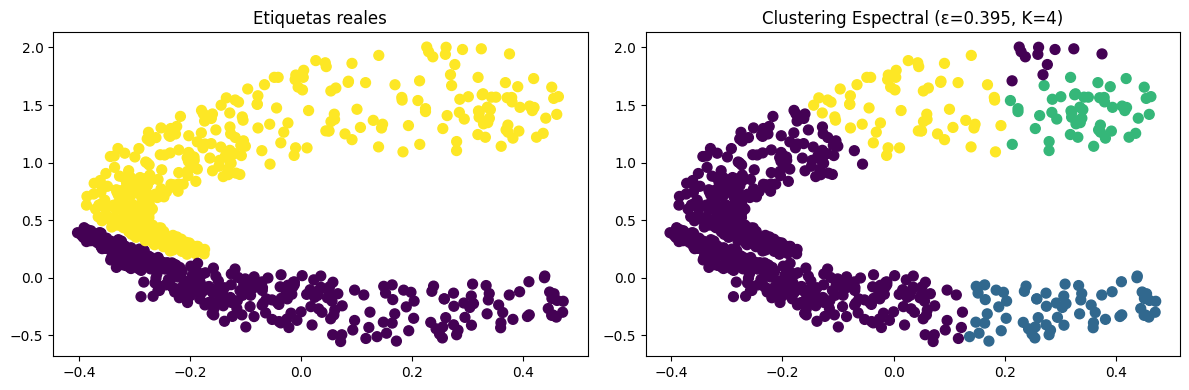


--- Comparación de métodos ---
Método k-NN: 4 clusters encontrados
Método ε-vecindad: 4 clusters encontrados

--- Método 3: SpectralClustering de sklearn ---


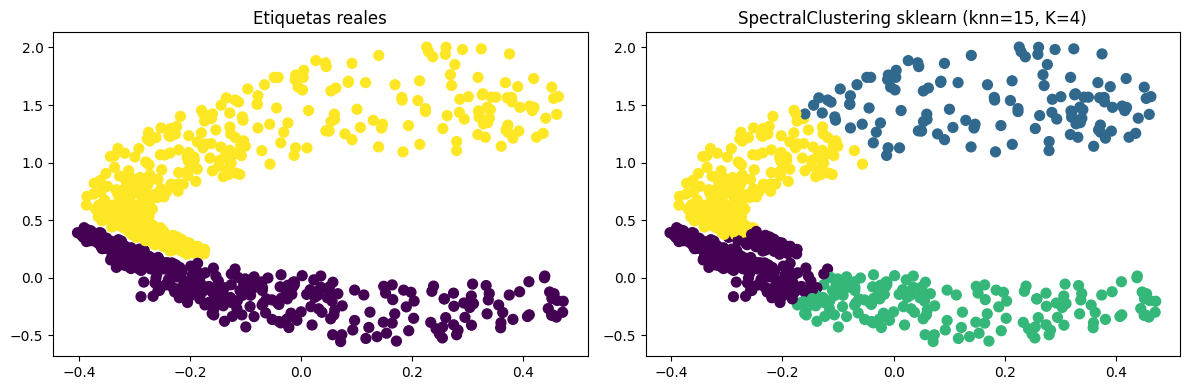

In [41]:
# p21: Clustering espectral para dataset_cuatro_diferente_medida

# Visualizar los datos primero
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 1. Datos con etiquetas reales
ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=30)
ax1.set_title('Dataset cuatro diferente medida - Etiquetas reales')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

# 2. Sin etiquetas
ax2.scatter(Dx[:, 0], Dx[:, 1], s=30)
ax2.set_title('Dataset cuatro diferente medida - Sin etiquetas')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')

plt.tight_layout()
plt.show()

# Escalar datos para normalizar diferentes medidas
scaler = StandardScaler()
Dx_scaled = scaler.fit_transform(Dx)

# Determinar K - basado en la estructura del dataset
K = 4  # Cuatro clusters visibles

print(f"K seleccionado: {K}")

# Método 1: Clustering espectral con k-NN (mejor para escalas diferentes)
print("\n--- Método 1: k-NN con Laplaciano normalizado ---")

# Calcular parámetros
knn = 15  # Valor moderado para k-NN
distancias = euclidean_distances(Dx_scaled)
sigma = np.median(distancias[np.triu_indices(distancias.shape[0], k=1)][distancias[np.triu_indices(distancias.shape[0], k=1)] > 0])

# Aplicar clustering espectral
mAfinidad, Dyp = agrupamiento_espectral(Dx_scaled, K, grafo_knn, matriz_Laplaciana_normalizada,
                                        knn=knn, sigma=sigma, modo='interseccion')

# Graficar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=50)
ax1.set_title('Etiquetas reales')

ax2.scatter(Dx[:, 0], Dx[:, 1], c=Dyp, cmap='viridis', s=50)
ax2.set_title(f'Clustering Espectral (k-NN={knn}, K={K})')

plt.tight_layout()
plt.show()

# Método 2: Probar con ε-vecindad para comparar
print("\n--- Método 2: ε-vecindad ---")

epsilon = np.percentile(distancias[np.triu_indices(distancias.shape[0], k=1)], 10)  # Percentil 10
sigma_epsilon = epsilon

mAfinidad2, Dyp2 = agrupamiento_espectral(Dx_scaled, K, grafo_epsilon, laplaciano_no_normalizado,
                                          epsilon=epsilon, sigma=sigma_epsilon)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=50)
ax1.set_title('Etiquetas reales')

ax2.scatter(Dx[:, 0], Dx[:, 1], c=Dyp2, cmap='viridis', s=50)
ax2.set_title(f'Clustering Espectral (ε={epsilon:.3f}, K={K})')

plt.tight_layout()
plt.show()

# Comparar resultados
print("\n--- Comparación de métodos ---")
print(f"Método k-NN: {len(np.unique(Dyp))} clusters encontrados")
print(f"Método ε-vecindad: {len(np.unique(Dyp2))} clusters encontrados")

# Usar SpectralClustering de sklearn para comparar
from sklearn.cluster import SpectralClustering

print("\n--- Método 3: SpectralClustering de sklearn ---")

clustering = SpectralClustering(n_clusters=K,
                                affinity='nearest_neighbors',
                                n_neighbors=knn,
                                random_state=42).fit(Dx_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(Dx[:, 0], Dx[:, 1], c=Dy, cmap='viridis', s=50)
ax1.set_title('Etiquetas reales')

ax2.scatter(Dx[:, 0], Dx[:, 1], c=clustering.labels_, cmap='viridis', s=50)
ax2.set_title(f'SpectralClustering sklearn (knn={knn}, K={K})')

plt.tight_layout()
plt.show()

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


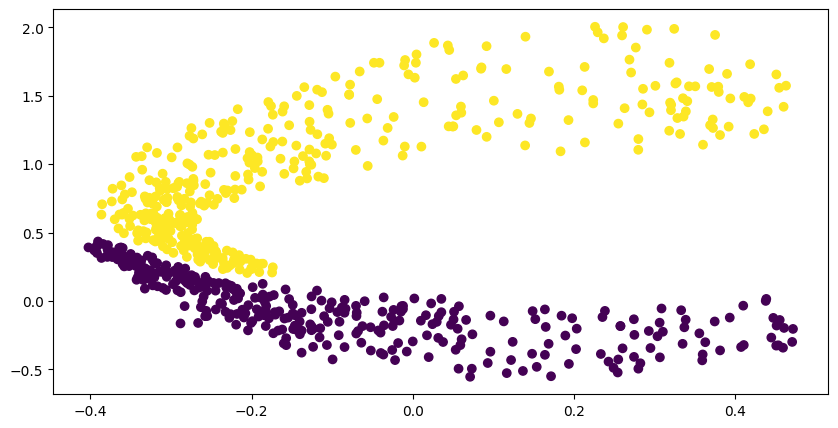

In [42]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K,
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

Que metodo funciona mejor para los 5 Dataset y porque?


*   dataset_circulos_concentricos
*   dataset_cuatro_diferente_densidad
*   dataset_cuatro_separables_peque
*   dataset_cuatro_diferente_medida
*   dataset_inseparable



**Dataset círculos concéntricos:**
Funciona mejor k-NN con Laplaciano normalizado. Los círculos tienen la misma densidad pero distancias radiales diferentes. k-NN conecta puntos dentro del mismo círculo sin cruzar entre círculos, y el Laplaciano normalizado suaviza las conexiones. El modo 'mutuo' o 'intersección' evita enlaces entre anillos.

**Dataset diferente densidad:**
El mejor es k-NN con Laplaciano normalizado simétrico. k-NN se adapta automáticamente a la densidad local: más vecinos en zonas densas, menos en zonas dispersas. El Laplaciano simétrico normalizado maneja mejor la variación de grados entre clusters.

**Dataset separables pequeños:**
Basta con ε-vecindad y Laplaciano no normalizado. Los clusters están bien separados y son compactos, por lo que un radio fijo conecta bien dentro de cada grupo y el Laplaciano simple es suficiente. Es el método más rápido y directo.

**Dataset diferente medida:**
Se necesita k-NN después de escalar los datos. Las diferentes escalas distorsionan las distancias; el escalado previo (StandardScaler) normaliza las características. k-NN, al usar rangos locales, es robusto tras el escalado, mientras que ε-vecindad fallaría.

**Dataset inseparable:**
Ningún clustering espectral funciona bien si realmente no hay estructura separable. En tal caso, es mejor usar métodos basados en densidad como DBSCAN, o reconsiderar si es necesario hacer clustering.

# 🚀 ¡TALLER FINALIZADO!"